Processing file: input/sinData.txt
{'file_name': 'sinData.txt', 'contains_Complex': False, 'contains_LUT': False, 'OSR': 1.0, 'fs': 10000.0, 'complex': 0.0}
1
1
Saved spectrum plot to ./figs/sinData_spectrum.png


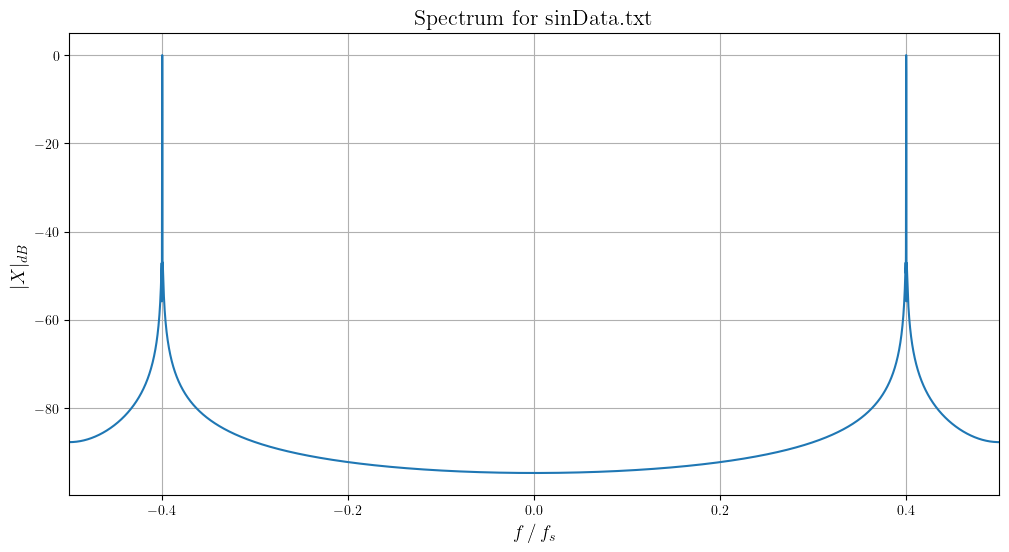

Processed real data from input/sinData.txt
Processing file: output/sinData_fir.txt
{'file_name': 'sinData_fir.txt', 'contains_Complex': False, 'contains_LUT': False, 'OSR': 1.0, 'complex': 0.0, 'fs': 10000.0}
1
1
Saved spectrum plot to ./figs/sinData_fir_spectrum.png


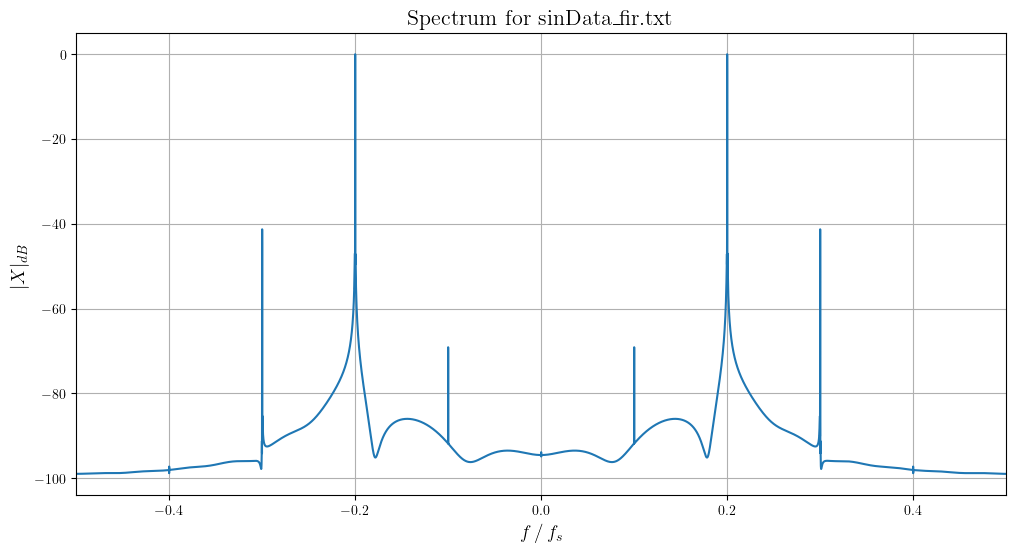

Processed real data from output/sinData_fir.txt
Processing file: input/sinDataComplex.txt
{'file_name': 'sinDataComplex.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 1.0, 'fs': 10000.0, 'complex': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataComplex_spectrum.png


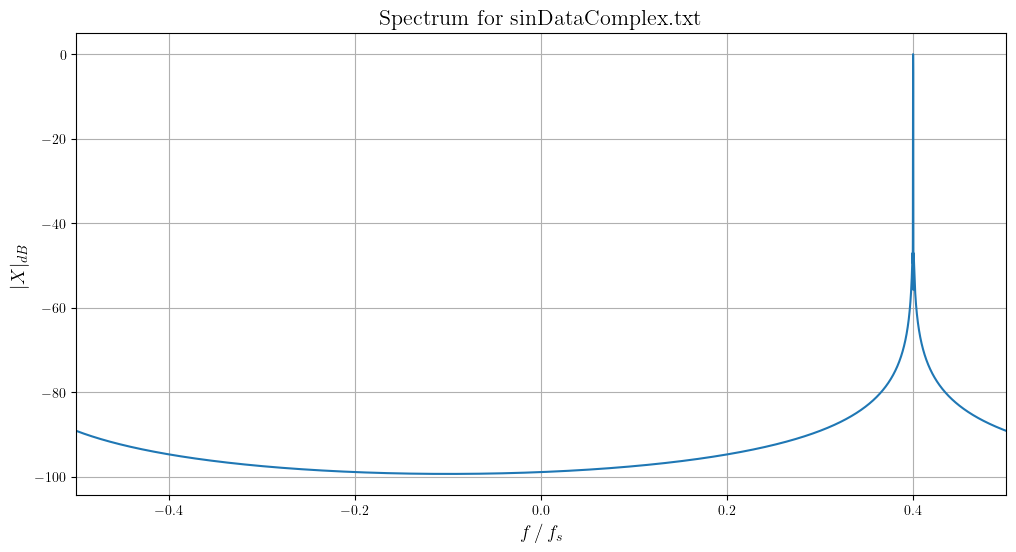

Processed complex data from input/sinDataComplex.txt
Processing file: output/sinDataComplex_fir.txt
{'file_name': 'sinDataComplex_fir.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 1.0, 'complex': 1.0, 'fs': 10000.0}
1
1
Saved spectrum plot to ./figs/sinDataComplex_fir_spectrum.png


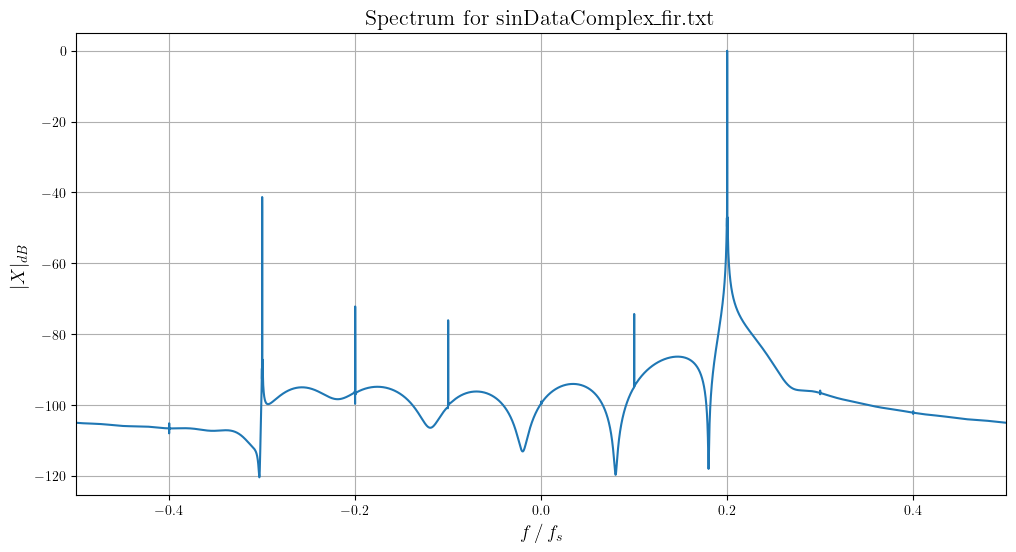

Processed complex data from output/sinDataComplex_fir.txt


In [13]:
#!/usr/bin/env python3

import os
import sys
import numpy as np
import scipy.signal as signal
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def read_file_with_header(file_path):
    """
    Reads a file with metadata in the header and numerical data below.
    Checks the filename for specific keywords like 'Complex' or 'LUT'.
    
    Args:
        file_path (str): Path to the input file.
    
    Returns:
        dict: Metadata key-value pairs, including file name details.
        np.ndarray: Numerical data as a NumPy array.
    """
    metadata = {}
    data = []

    # Extract the filename
    file_name = os.path.basename(file_path)
    metadata['file_name'] = file_name  # Store the filename in metadata

    # Check if the filename contains specific keywords
    metadata['contains_Complex'] = 'Complex' in file_name
    metadata['contains_LUT'] = 'LUT' in file_name

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                key_value = line[1:].strip().split("=")  # Metadata in format `key=value`
                if len(key_value) == 2:
                    key, value = key_value[0].strip(), key_value[1].strip()
                    try:
                        # Convert numeric metadata to float if possible
                        metadata[key] = float(value) if value.replace('.', '', 1).isdigit() else value
                    except ValueError:
                        metadata[key] = value
            else:
                try:
                    # Read data based on metadata
                    if metadata.get('complex', 0) == 1:  # If complex metadata is 1
                        real, imag = map(float, line.strip().split())
                        data.append(complex(real, imag))
                    else:  # If complex metadata is 0
                        data.append(float(line.strip()))
                except ValueError:
                    pass  # Ignore non-numeric lines

    return metadata, np.array(data)

def process_file(file_path):
    """
    Processes a single file, extracting metadata, computing the spectrum, and saving plots.
    
    Args:
        file_path (str): Path to the file.
    """
    print(f"Processing file: {file_path}")
    metadata, data = read_file_with_header(file_path)
    print(metadata)

    if not data.size:
        print(f"Warning: No valid numerical data found in {file_path}")
        return

    # Extract metadata
    OSR = int(metadata.get("OSR", 1))
    is_complex = metadata.get("complex", 0) == 1  # Check if the data is complex
    lut_width = metadata.get("lut_width", 1)

    # Compute the windowed data and spectrum
    print(lut_width)
    w = signal.windows.hamming(len(data), False)
    data_win = data * w
    spectrum = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data_win))))
    spectrum -= np.max(spectrum)
    freqs = (np.arange(len(data)) / len(data) - 0.5)

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, spectrum, label="Spectrum")
    plt.title(f"Spectrum for {os.path.basename(file_path)}", fontsize=16)
    plt.xlabel(r"$f \, / \, f_s$", fontsize=14)
    plt.ylabel(r"$|X|_{dB}$", fontsize=14)

    print(lut_width)
    x_min = -0.5/lut_width
    x_max = 0.5/lut_width
    y_min = np.min(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])
    y_max = np.max(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])

    plt.xlim([x_min, x_max])
    plt.ylim(y_min - 5, y_max + 5)

    plt.grid()

    # Save the figure
    file_name = os.path.basename(file_path).replace('.txt', '_spectrum.png')
    fig_path = os.path.join("./figs", file_name)
    plt.savefig(fig_path)
    print(f"Saved spectrum plot to {fig_path}")
    # plt.close()
    plt.show();

    # Additional printout for complex vs real
    data_type = "complex" if is_complex else "real"
    print(f"Processed {data_type} data from {file_path}")

def main():
    file_path = "input/sinData.txt"
    process_file(file_path)
    file_path = "output/sinData_fir.txt"
    process_file(file_path)

    file_path = "input/sinDataComplex.txt"
    process_file(file_path)
    file_path = "output/sinDataComplex_fir.txt"
    process_file(file_path)
    
    # file_path = "output/sinData_deltaSigma.txt"
    # process_file(file_path)

    # file_path = "output/sinDataComplex_deltaSigma.txt"
    # process_file(file_path)

    # file_path = "output/sinData_serial.txt"
    # process_file(file_path)

    # file_path = "output/sinDataComplex_serial.txt"
    # process_file(file_path)

if __name__ == "__main__":
    main()


In [9]:

firResponse = [1.0, 1.0, 0, 0]
firFreqs = [0, 0.2, 0.3, 0.5]
firCoeff = signal.firls(5, firFreqs, firResponse, fs=1)
print(firCoeff)

[-2.63665205e-17  3.06687619e-01  5.00000000e-01  3.06687619e-01
 -2.63665205e-17]


In [23]:
import scipy.signal
import numpy

def remezlp( Fpass, Fstop, deltaPass, deltaStop, forceOrder='none', nPoints=8192, Nmax=200):
    """
    Design low pass FIR filter with given specifications.
    Parameter forceOrder can be used to force even or odd filter order
    """
    
    if (Fpass>Fstop) or (deltaPass<0) or (deltaStop<0):
        # Specifications are not valid
        return numpy.array([])
    
    remez = scipy.signal.remez
    freqz = scipy.signal.freqz
    
    # Filter order initial guess
    N = int(-20*numpy.log10(deltaStop)/(23*(Fstop-Fpass)))
    # Scipy Remez uses number of taps instead of filter order.
    if forceOrder == 'even':
        if N%2==0:
            N += 1
    if forceOrder == 'odd':
        if N%2==1:
            N += 1
            
    while N<Nmax:
        # Design the filter.
        b = scipy.signal.remez(N, [0.0, Fpass, Fstop, 0.5], [1, deltaPass/deltaStop])
        
        # Check if filter meets specifications
        w, h = freqz(b, 1, worN = nPoints, fs=1)
        H = abs(h)
        specOK = True
        # Check specifications in pass band
        if numpy.sum(((w<Fpass)*abs(H-1.0))>deltaPass)>0:
            specOK = False
        if numpy.sum(((w>Fstop)*H)>deltaStop)>0:
            specOK = False
    
        if specOK:
            return b
        else:
            if (forceOrder == 'even') or (forceOrder == 'odd'):
                N += 2
            else:
                N += 1
    return []
    



In [26]:
import numpy as np
import scipy.signal
# from remezlp import *

N = 1024

M = 3
I = 2

Fmax = 0.4
Fpass = Fmax
Fstop = 1 - Fpass
AdB = 40
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

iterator = int(np.log(I)/np.log(2))
# xI = x
Fpass_ = Fpass
Fstop_ = Fstop

for i in range(iterator):
    Fpass_ /= 2
    Fstop_ /= 2
    firCoeff = remezlp(Fpass_, Fstop_, deltaPass, deltaStop, nPoints=N, Nmax=500)
    print(f"N = {len(firCoeff)}")
    print(firCoeff)
    # firCoeff = firCoeff[1:-1]

    # xI = expander(xI, 2)
    # xI = signal.lfilter(firCoeff, 1.0, np.concatenate((xI, xI[:len(firCoeff)-1])))[len(firCoeff)-1:]    
    # xI = polyI(xI, firCoeff, 2)
    
    # plotdB(xI)
    # plt.plot([-0.5,0.5], [-AdB, -AdB], '--r')
    # plt.show();

ValueError: Failure to converge at iteration 2, try reducing transition band width.


In [4]:
import numpy as np
from remezlp import *

Fpass = 0.4
Fstop = 0.6
deltaPass = 0.01
deltaStop = 0.01
N = 1024

firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, nPoints=N, Nmax=500)
if len(firCoeff) > 0:
    print(f"Filter coefficients: {firCoeff}")
else:
    print("Failed to design filter.")



TypeError: remez() takes 3 positional arguments but 4 were given

In [3]:
import scipy.signal
help(scipy.signal.remez)


Help on function remez in module scipy.signal._fir_filter_design:

remez(numtaps, bands, desired, *, weight=None, type='bandpass', maxiter=25, grid_density=16, fs=None)
    Calculate the minimax optimal filter using the Remez exchange algorithm.

    Calculate the filter-coefficients for the finite impulse response
    (FIR) filter whose transfer function minimizes the maximum error
    between the desired gain and the realized gain in the specified
    frequency bands using the Remez exchange algorithm.

    Parameters
    ----------
    numtaps : int
        The desired number of taps in the filter. The number of taps is
        the number of terms in the filter, or the filter order plus one.
    bands : array_like
        A monotonic sequence containing the band edges.
        All elements must be non-negative and less than half the sampling
        frequency as given by `fs`.
    desired : array_like
        A sequence half the size of bands containing the desired gain
        in e

In [13]:
import numpy as np
from scipy.signal import remez, freqz

def remezlp(Fpass, Fstop, deltaPass, deltaStop, forceOrder='none', nPoints=8192, Nmax=200):
    """
    Design an optimized low-pass FIR filter using the Remez exchange algorithm.
    
    Parameters:
    -----------
    Fpass : float
        Normalized passband edge frequency (0 < Fpass < 0.5).
    Fstop : float
        Normalized stopband edge frequency (Fstop > Fpass).
    deltaPass : float
        Allowed ripple in the passband.
    deltaStop : float
        Allowed ripple in the stopband.
    forceOrder : str, optional
        Force filter order to be 'even' or 'odd'. Default is 'none'.
    nPoints : int, optional
        Number of frequency points for validation. Default is 8192.
    Nmax : int, optional
        Maximum number of filter taps. Default is 200.

    Returns:
    --------
    np.ndarray
        FIR filter coefficients. Returns an empty array if the design fails.
    """
    if Fpass >= Fstop or deltaPass <= 0 or deltaStop <= 0:
        raise ValueError("Invalid filter specifications: Fpass < Fstop, deltaPass > 0, deltaStop > 0 required.")

    # Initial guess for the number of taps
    N = int(-20 * np.log10(deltaStop) / (23 * (Fstop - Fpass)))

    # Adjust the order based on forceOrder
    if forceOrder == 'even' and N % 2 == 0:
        N += 1
    elif forceOrder == 'odd' and N % 2 == 1:
        N += 1

    # Iteratively design the filter
    while N <= Nmax:
        # Design filter using remez
        try:
            b = remez(
                numtaps=N,
                bands=[0.0, Fpass, Fstop, 0.5],
                desired=[1, 0],
                weight=[1, deltaPass / deltaStop],
                fs=1.0  # Normalized frequency
            )
        except ValueError as e:
            print(f"Error in remez design: {e}")
            return np.array([])

        # Validate the filter using frequency response
        w, h = freqz(b, worN=nPoints, fs=1.0)
        H = np.abs(h)

        passband_ok = np.all(H[w <= Fpass] >= (1 - deltaPass))
        stopband_ok = np.all(H[w >= Fstop] <= deltaStop)

        if passband_ok and stopband_ok:
            return b  # Filter meets specifications
        else:
            N += 2 if forceOrder in ['even', 'odd'] else 1

    return np.array([])  # Return empty array if design fails


import numpy as np

Fpass = 0.2
Fstop = 0.3
deltaPass = 0.01
deltaStop = 0.01
N = 1024

firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, nPoints=nPoints, Nmax=Nmax)
if firCoeff.size > 0:
    print(f"Filter designed successfully with {len(firCoeff)} coefficients.")
else:
    print("Failed to design filter.")


Filter designed successfully with 22 coefficients.


In [11]:
# Signal parameters
N = 8 * 1024
M = 3
OSR = 1
f = 4 * 1e3
fs = 10 * 1e3

F = f / fs
# x = 2**(M-1) * np.sin(2 * np.pi * F * np.arange(N) / OSR)
x = 2**(M-1) * np.exp(1j * 2 * np.pi * F * np.arange(N) / OSR)

[ 4.         -3.23606798  1.23606798 ... -3.23606798  4.
 -3.23606798]


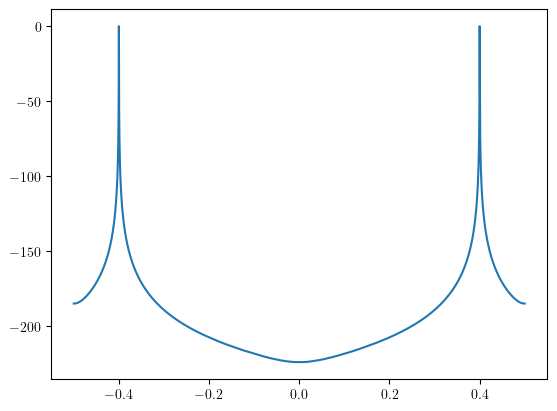

In [15]:
x_ = x.real
w = signal.windows.hann(len(x_), False)
data_win = x_ * w
spectrum = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data_win))))
spectrum -= np.max(spectrum)
freqs = (np.arange(len(x_)) / len(x_) - 0.5)

plt.plot(freqs, spectrum)